In [248]:
# MLE Chart of Nuclides Project Decay Classifier
# Nicholas March
# 661848406

# Imports
import numpy as np
from nuclide_data import nuclide_data as nd
import periodictable
from fractions import Fraction
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, log_loss, brier_score_loss

In [249]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Number of Primary Decay Types: 8
Decay Type   # of Instances   % of Total Instances
Stable		 295		8.8323%
B-		 1268		37.9641%
N		 24		0.7186%
A		 480		14.3713%
P		 78		2.3353%
EC		 1113		33.3234%
Other		 15		0.4491%
SF		 67		2.006%


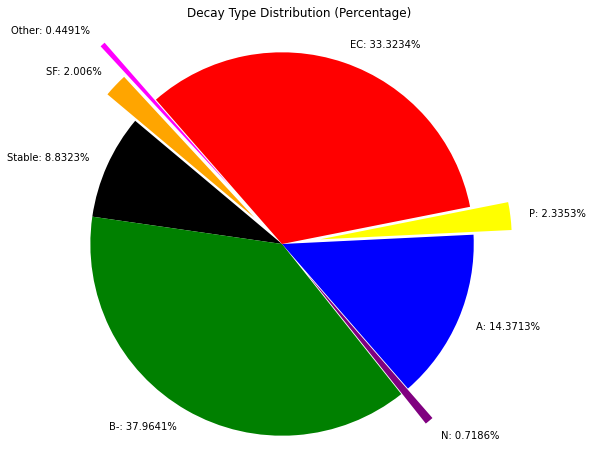

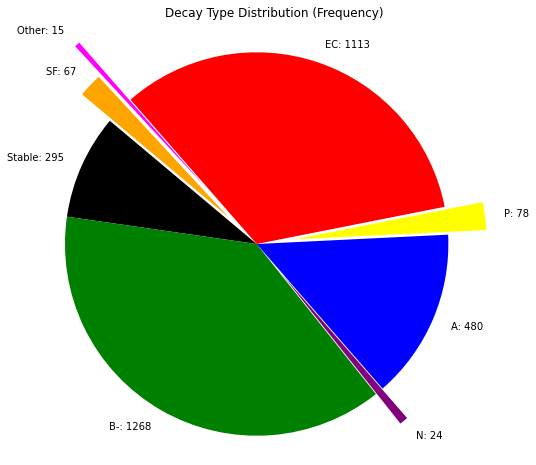

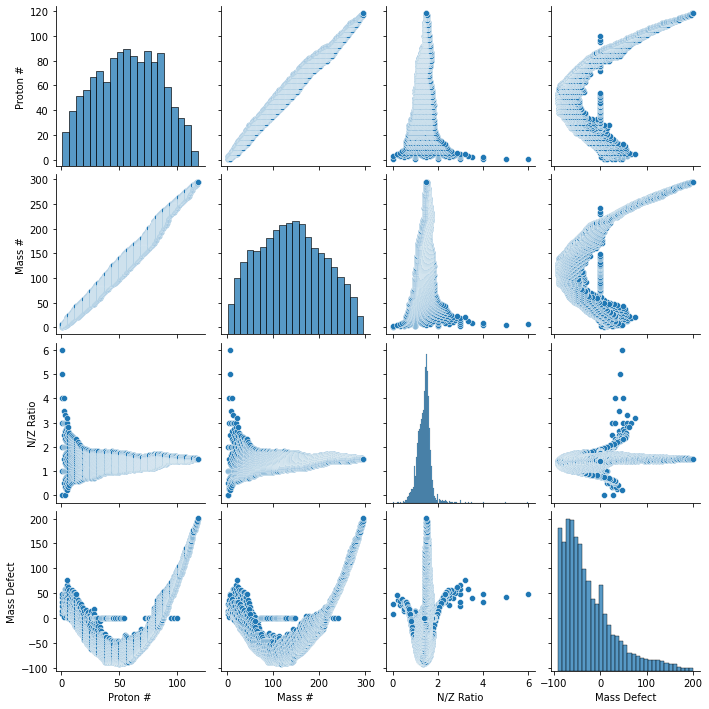


Feature Training Data Shape: (2338, 4)
Feature Testing Data Shape: (1002, 4)
Target Training Data Shape: (2338,)
Target Testing Data Shape: (1002,)


In [270]:
# Data Preprocessing

# Define data arrays and labels
x_data = []
y_data = []
feature_lbls = ["Proton #","Mass #","N/Z Ratio",
                "Mass Defect"]

# Read in feature and target data
Z_num = 1
while(Z_num < 120):
    A_num = Z_num
    nonexistent = 0
    while(nonexistent < 300):
        try:
            y_data.append(nd.nuclides[(Z_num, A_num)][0]['decay modes'])
            x_data.append([Z_num, A_num, (float(A_num/Z_num)-1.0), 
                           float(str(nd.nuclides[(Z_num, A_num)][0]['mass excess']).split("+")[0])])
        except KeyError:
            nonexistent += 1
        A_num += 1
    Z_num += 1
    
# Remove decay types besides primary
for i in range(len(y_data)):
    length = len(list(y_data[i].keys()))
    while(length > 1):
        y_data[i].popitem()
        length = len(list(y_data[i].keys()))

# Reformat label data
for i in range(len(y_data)):
    y_data[i] = str(list(y_data[i].keys())[-1])

# Determine decay types
decay_types = {}
total = 0
for i in range(len(y_data)):
    total += 1
    if y_data[i] == "None":
        y_data[i] = "Stable"
    if y_data[i] in ["2N?", "2N"]:
        y_data[i] = "N"
    if y_data[i] == "2B-":
        y_data[i] = "B-"
    if y_data[i] == "2EC":
        y_data[i] = "EC"
    if y_data[i] in ["2P", "BN", "EP"]:
        y_data[i] = "Other"
    if y_data[i] not in list(decay_types.keys()):
        decay_types[y_data[i]] = 1
    else:
        decay_types[y_data[i]] = decay_types[y_data[i]] + 1
            
# Print decay type information
print("Number of Primary Decay Types:",len(list(decay_types.keys())))
print("Decay Type   # of Instances   % of Total Instances")
percent_arr = list()
for entry in decay_types:
    percentage = round(100.0*float(decay_types[entry])/float(total),4)
    percent_arr.append(percentage)
    print(str(entry) + "\t\t", str(decay_types[entry]) + "\t\t" +
          str(percentage)+"%")

# Display pie plot showing class balance with percents
pie_colors = ['black', 'green', 'purple', 'blue', 'yellow', 'red', 'magenta', 'orange']
explode = (0, 0, 0.2, 0, 0.2, 0, 0.4, 0.2)
fig, ax = plt.subplots(figsize=(8, 8))
pie_lbl = []
for i in range(len(list(decay_types.keys()))):
    temp_str = list(decay_types.keys())[i] + ": " + str(percent_arr[i]) + "%"
    pie_lbl.append(temp_str)
plt.pie(percent_arr, explode=explode, labels=pie_lbl, colors=pie_colors,
        startangle=140)
plt.axis('equal')  
plt.title('Decay Type Distribution (Percentage)')
plt.show()

# Display pie plot showing class balance with frequency
pie_colors = ['black', 'green', 'purple', 'blue', 'yellow', 'red', 'magenta', 'orange']
explode = (0, 0, 0.2, 0, 0.2, 0, 0.4, 0.2)
fig, ax = plt.subplots(figsize=(8, 8))
pie_lbl = []
for decay in list(decay_types.keys()):
    temp_str = decay + ": " + str(decay_types[decay])
    pie_lbl.append(temp_str)
plt.pie(percent_arr, explode=explode, labels=pie_lbl, colors=pie_colors,
        startangle=140)
plt.axis('equal')  
plt.title('Decay Type Distribution (Frequency)')
plt.show()
    
# Convert to label-encoded format
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_data)

# Reformat data into numpy arrays
x_data = np.array(x_data)
y_data = np.array(y_encoded)

# Visualize feature data via pair plot
pairplot_data = pd.DataFrame(x_data, columns=feature_lbls)
sns.pairplot(pairplot_data)
plt.show()

# Split data into training and testing arrays
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data,
                                                    test_size=0.3,
                                                    random_state=5)    

# Display data shapes
print("\nFeature Training Data Shape:",x_train.shape)
print("Feature Testing Data Shape:",x_test.shape)
print("Target Training Data Shape:",y_train.shape)
print("Target Testing Data Shape:",y_test.shape)

In [73]:
# Ensemble Creation and Training

# Define individual models
model1 = CalibratedClassifierCV(RidgeClassifier(class_weight='balanced'), method='sigmoid', cv=5)
model2 = RandomForestClassifier(class_weight='balanced')
model3 = KNeighborsClassifier()
model4 = MLPClassifier()

# Create the VotingClassifier
voting_clf = VotingClassifier(estimators=[
    ('ridge', model1),
    ('rf', model2),
    ('knn', model3),
    ('mlp', model4)
], voting='soft')

# Define paramater space
param_space = {
    'ridge__base_estimator__alpha': [0.1, 1.0, 10.0],
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'knn__n_neighbors': [3, 5, 7, 10],
    'mlp__hidden_layer_sizes': [(64,), (128,), (128, 64), (256, 128, 64)],
    'mlp__learning_rate_init': [0.001, 0.01, 0.1]
}

# Define the cross-validation scheme
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run grid search
grid_search = GridSearchCV(estimator=voting_clf, param_grid=param_space, 
                           cv=skf, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(x_train, y_train)

# Output best parameters
print("Best parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 1728 candidates, totalling 8640 fits


C:\Users\ncmar\anaconda3\lib\site-packages\sklearn\base.py:263: FutureWarning: Parameter 'base_estimator' of CalibratedClassifierCV is deprecated in favor of 'estimator'. See CalibratedClassifierCV's docstring for more details.
  valid_params[key].set_params(**sub_params)


Best parameters found:  {'knn__n_neighbors': 7, 'mlp__hidden_layer_sizes': (256, 128, 64), 'mlp__learning_rate_init': 0.001, 'rf__max_depth': 10, 'rf__n_estimators': 50, 'ridge__base_estimator__alpha': 1.0}


In [184]:
# Model Calibration

# Calibrate model
calibrated_model = CalibratedClassifierCV(base_estimator=best_model, method='sigmoid', cv=5)

# Train calibrated model
calibrated_model.fit(x_train, y_train)

C:\Users\ncmar\anaconda3\lib\site-packages\sklearn\calibration.py:300: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


CalibratedClassifierCV(base_estimator=VotingClassifier(estimators=[('ridge',
                                                                    CalibratedClassifierCV(cv=5,
                                                                                           estimator=RidgeClassifier(class_weight='balanced'))),
                                                                   ('rf',
                                                                    RandomForestClassifier(class_weight='balanced',
                                                                                           max_depth=10,
                                                                                           n_estimators=50)),
                                                                   ('knn',
                                                                    KNeighborsClassifier(n_neighbors=7)),
                                                                   ('mlp',
                                                                    MLPClassifier(hidden_layer_sizes=(256,
                                                                                                      128,
                                                                                                      64)))],
                                                       voting='soft'),
                       cv=5)

              precision    recall  f1-score   support

           A       0.66      0.79      0.72       150
          B-       0.93      0.95      0.94       379
          EC       0.84      0.90      0.87       325
           N       0.30      1.00      0.46         3
       Other       0.00      0.00      0.00         5
           P       0.56      0.15      0.23        34
          SF       0.33      0.05      0.08        21
      Stable       0.66      0.48      0.56        85

    accuracy                           0.82      1002
   macro avg       0.53      0.54      0.48      1002
weighted avg       0.80      0.82      0.80      1002



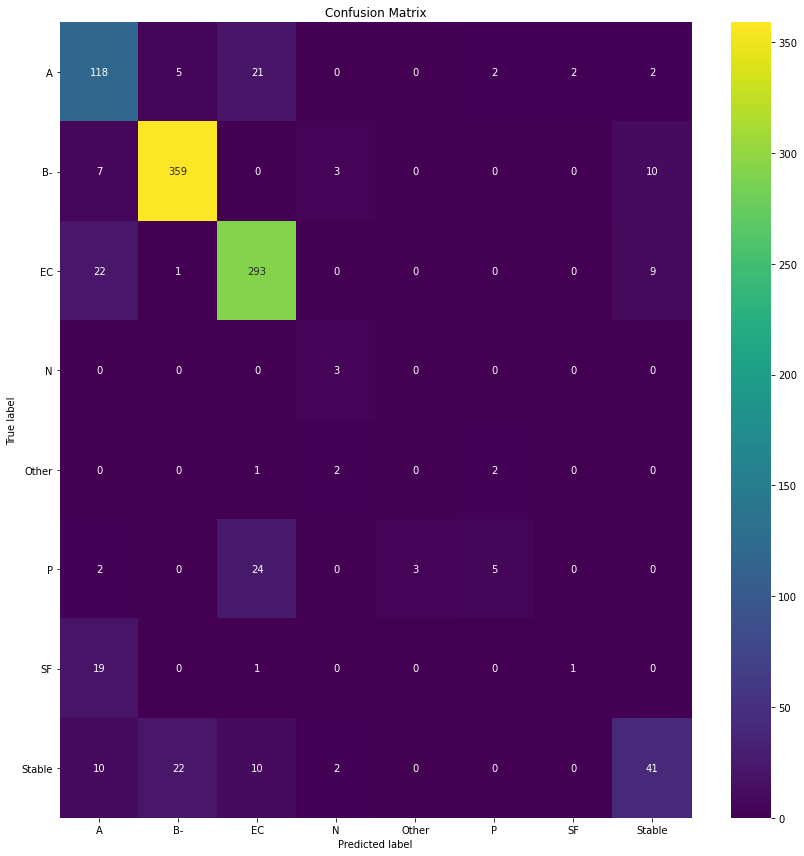

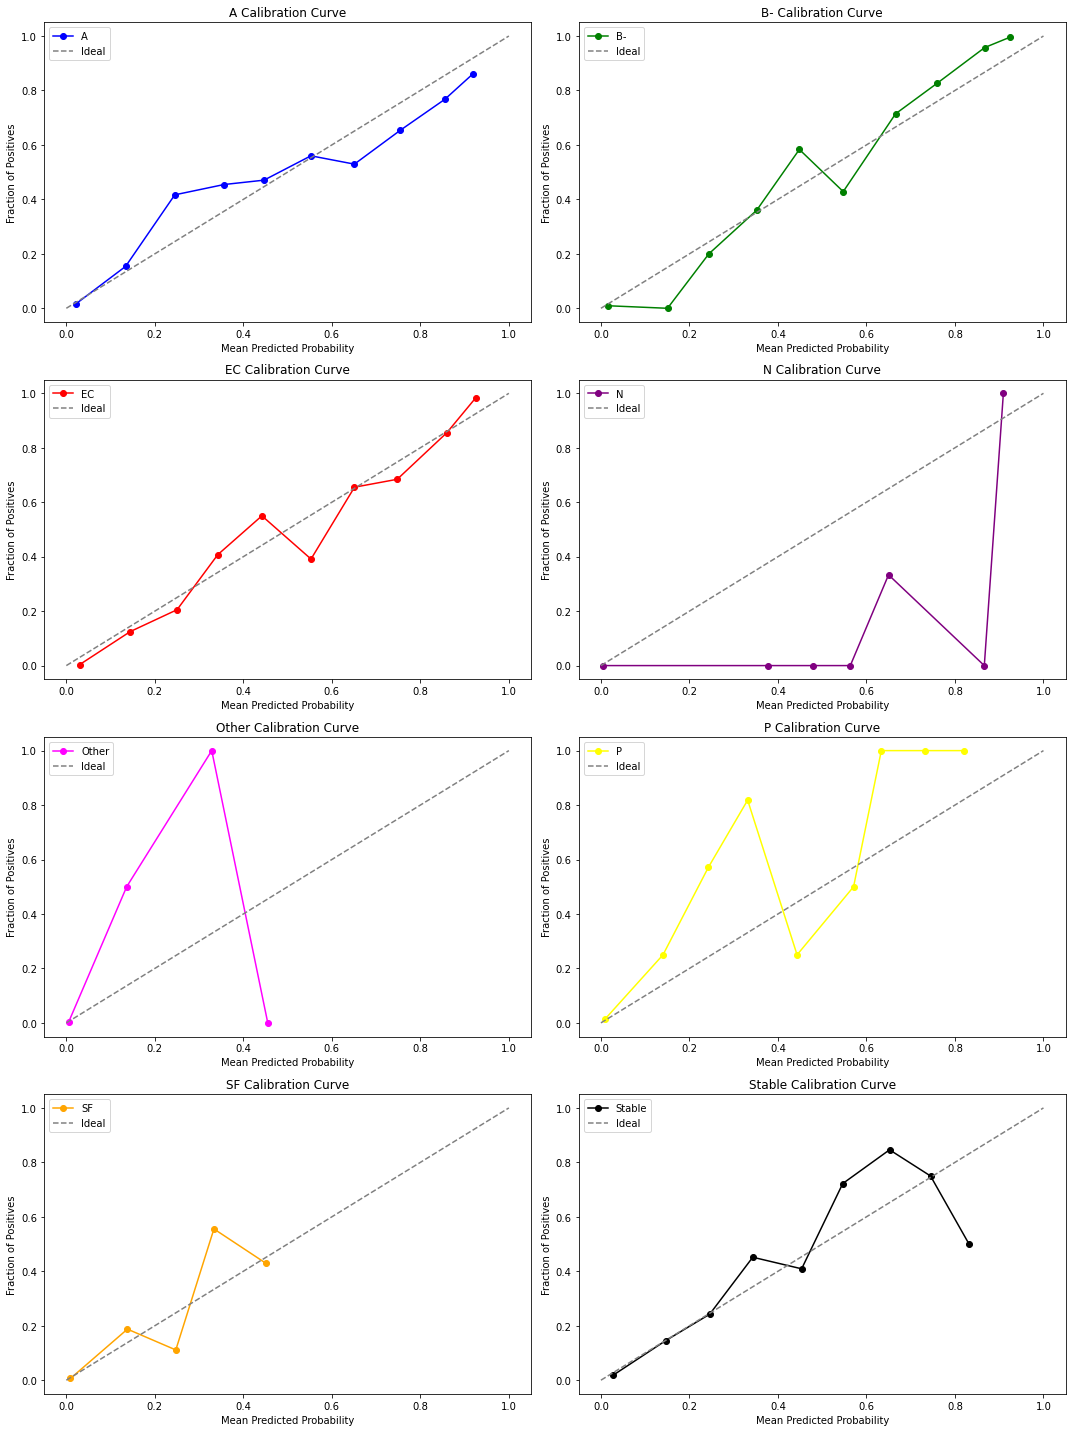

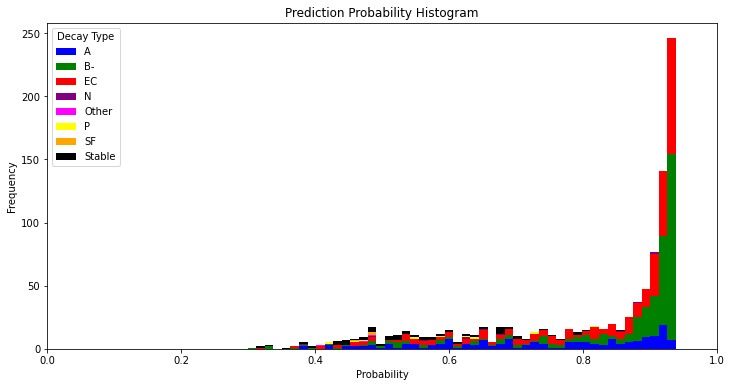

Log Loss: 0.50228 

Brier score for A: 0.06011
Brier score for B-: 0.03349
Brier score for EC: 0.05864
Brier score for N: 0.00318
Brier score for Other: 0.00457
Brier score for P: 0.02189
Brier score for SF: 0.01596
Brier score for Stable: 0.04899

Mean Brier score: 0.03086


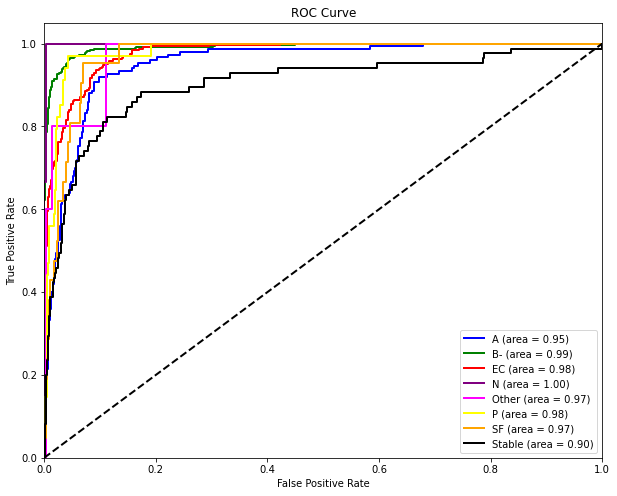

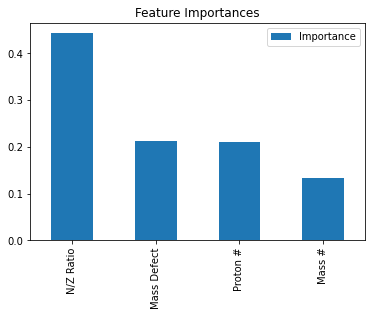

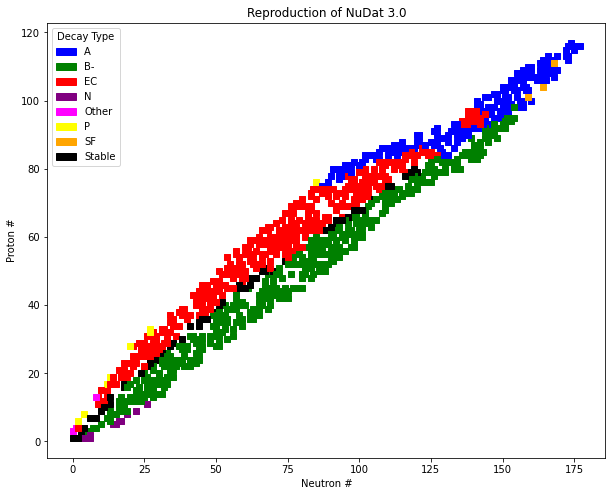

In [244]:
# Results

# Define color scheme
colors = ['blue', 'green', 'red', 'purple', 'magenta', 'yellow', 'orange', 'black']

# Make predictions
encoded_preds = calibrated_model.predict(x_test)
predictions = encoder.inverse_transform(encoded_preds)
probabilities = calibrated_model.predict_proba(x_test)
print(classification_report(encoder.inverse_transform(y_test), predictions))

# Display confusion matrix
cm = confusion_matrix(encoder.inverse_transform(y_test), predictions)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt="d", cmap='viridis',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.yticks(rotation=0)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Display calibration plots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20))
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i < len(encoder.classes_):
        true_prob, predicted_prob = calibration_curve(y_test == i, probabilities[:, i], n_bins=10)
        ax.plot(predicted_prob, true_prob, color=colors[i], marker='o', label=encoder.classes_[i])
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Ideal')
        ax.set_title(f'{encoder.classes_[i]} Calibration Curve')
        ax.set_xlabel('Mean Predicted Probability')
        ax.set_ylabel('Fraction of Positives')
        ax.legend()
plt.tight_layout()
plt.show()

# Extract the highest probabilities
prob_matrix = [[],[],[],[],[],[],[],[]]
for sample in probabilities:
    index = np.argmax(sample)
    prob_matrix[index].append(max(sample))
    
# Display probability histogram
plt.figure(figsize=(12, 6))
plt.hist(prob_matrix, bins=50, stacked=True, histtype='barstacked', color=colors)
plt.title('Prediction Probability Histogram')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.xlim(0, 1)
plt.legend(encoder.inverse_transform(calibrated_model.classes_), title='Decay Type', loc='best')
plt.show()

# Calculate loss metrics
log_loss_value = log_loss(y_test, probabilities)
print("Log Loss:",round(log_loss_value,5),"\n")

# Binarize labels
y_test_binarized = label_binarize(y_test, classes=np.unique(y_train))

# Calculate Brier scores
brier_scores = []
for i in range(probabilities.shape[1]):
    true_labels = y_test_binarized[:, i]
    class_probabilities = probabilities[:, i]
    brier_score = brier_score_loss(true_labels, class_probabilities)
    brier_scores.append(brier_score)
    print(f"Brier score for {encoder.classes_[i]}: {round(brier_score,5)}")

# If you want the mean Brier score across all classes
mean_brier_score = round(np.mean(brier_scores),5)
print(f"\nMean Brier score: {mean_brier_score}")

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i, color in enumerate(colors[:n_classes]):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (area = {1:0.2f})'.format(encoder.classes_[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Display feature importances
feature_importances = pd.DataFrame(calibrated_model.base_estimator.named_estimators_['rf'].feature_importances_,
                                   index = feature_lbls,
                                   columns=['Importance']).sort_values('Importance', ascending=False)
feature_importances.plot(kind='bar')
plt.title('Feature Importances')
plt.show()

# Reproduce NuDat 3
color_array = []
for i in range(len(encoded_preds)):
    color_array.append(colors[encoded_preds[i]])
N_num = x_test[:,0] * x_test[:,2]
plt.figure(figsize=(10, 8))
plt.scatter(N_num, x_test[:,0], color=color_array, marker='s')
plt.xlabel('Neutron #')
plt.ylabel('Proton #')
plt.title('Reproduction of NuDat 3.0')
legend_labels = encoder.inverse_transform(np.unique(encoded_preds))
legend_handles = [Patch(color=colors[i], label=label) for i, label in enumerate(legend_labels)]
plt.legend(handles=legend_handles, title='Decay Type', loc='best')
plt.show()